In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# dataset path
dataset_path = '/content/drive/My Drive/Colab Notebooks/NLP Projects/Document Categorization/Excel_Clean_Dataset/'
path = '/content/drive/My Drive/Colab Notebooks/NLP Projects/Document Categorization/'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [ ]:
print(tf.keras.__version__)

2.2.4-tf


#Importing Dataset

In [3]:
# Read the data
data = pd.read_csv(dataset_path+'News_12Class.csv',encoding='utf-8')
print(f'Total number of Documents: {len(data)}')


Total number of Documents: 95866


In [ ]:
data = data[['Text','Category']]

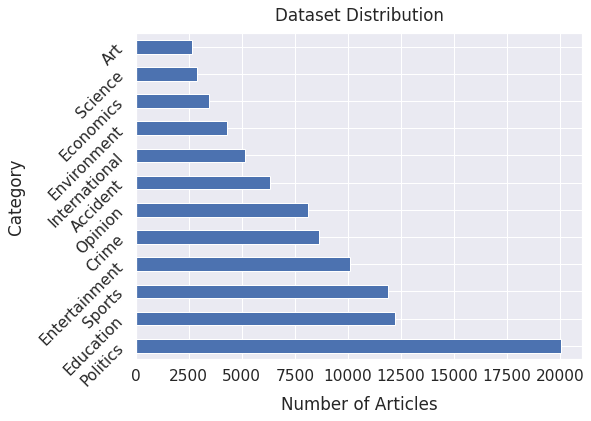

In [4]:
# Plot the Class distribution
sns.set(font_scale=1.4)
data['Category'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of Articles", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

The dataset has total 12 News Categories data and politics class has maximum number of articles. 

#Data Preparation and Cleaning

In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
      '''
      This function will clean the news articles by removing punctuation marks and stopwords.

      Args:
      articles: a news text(str)

      returns:
      news: clean text (str)
      '''
      news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(news)) #removing unnecessary punctuation
      # stopwords removal
      stp = open(path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

In [ ]:
# Apply the function into the dataframe
data['cleaned'] = data['Text'].apply(cleaning_documents)  

In [ ]:
# print some cleaned documents from the dataset
sample_data = [2000,5000,10000,20000,30000,35000,40000,45000,50000,60000,65000,70000,75000,80000]
for i in sample_data:
  print('Original:\n',data.Text[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Category:-- ',data.Category[i],'\n')   

Original:
 আরিচা মহাসড়কে এ দুর্ঘটনা ঘটে। নিহত মজিবুর রহমান (৩২) কুড়িগ্রাম জেলার রৌমারী থানার গোলাবাড়ি এলাকার আব্দুল হাইয়ের ছেলে। অপর আরোহীর রতন মিয়াকে (২৪)। মোটরসাইকেলে করে তারা ঢাকার দিকে যাচ্ছিলেন। প্রত্যক্ষদর্শীদের বরাত দিয়ে এসআই আশিষ বিডিনিউজ টোয়েন্টিফোর ডটকমকে বলেন, সকালের দিকে ব্যস্ত সড়কে মোটরসাইকেলটি দ্রুতবেগে এসে ‘ডিভাইডারে’ ধাক্কা খায়। এ সময় তারা রাস্তার বিপরীত দিকে ছিটকে পড়লে দ্রুতগতির একটি বাস চাপা দেয়। গুরুতর অবস্থায় তাদের হাসপাতালে নেয়া হলে মজিবুরকে মৃত ঘোষণা করেন চিকিৎসক। আশঙ্কাজনক অবস্থায় রতনকে ঢাকার পঙ্গু হাসপাতালে নিয়ে যাওয়ার পথে তিনিও মারা যান।   
Cleaned:
 আরিচা মহাসড়কে দুর্ঘটনা ঘটে নিহত মজিবুর রহমান ৩২ কুড়িগ্রাম জেলার রৌমারী থানার গোলাবাড়ি এলাকার আব্দুল হাইয়ের ছেলে অপর আরোহীর রতন মিয়াকে ২৪ মোটরসাইকেলে ঢাকার যাচ্ছিলেন প্রত্যক্ষদর্শীদের বরাত দিয়ে এসআই আশিষ বিডিনিউজ টোয়েন্টিফোর ডটকমকে সকালের ব্যস্ত সড়কে মোটরসাইকেলটি দ্রুতবেগে ডিভাইডারে ধাক্কা খায় সময় রাস্তার বিপরীত ছিটকে পড়লে দ্রুতগতির বাস চাপা দেয় গুরুতর অবস্থায় হাসপাতালে নেয়া মজিবুরকে মৃত ঘোষণা চিকিৎসক আশঙ্কাজনক অবস্

In [ ]:
# Stopwords pickle 
stp = open(path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()
# open a file, where you ant to store the data
file = open(path+'bangla_stopwords.pkl', 'wb')
# dump information to that file
pickle.dump(stp, file)

In [ ]:
stp = open(path+'bangla_stopwords.pkl','rb')
stp = pickle.load(stp)
len(stp)

398

## Handle Low Length Documents

In [ ]:
# Calculate the Length of each Document
data['Length'] = data.cleaned.apply(lambda x:len(x.split()))

# Remove the Documents with least words
dataset = data.loc[data.Length>20]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Documents".format(len(data)-len(dataset)),
      "\nTotal Remaining Documents:",len(dataset))

After Cleaning: 
Removed 908 Small Documents 
Total Remaining Documents: 94958


In [ ]:
# Save the Cleaned data for reuse
dataset.to_csv(dataset_path+'cleaned_news.csv')

In [ ]:
# Load the Cleaned News
dataset = pd.read_csv(dataset_path+'cleaned_news.csv')
dataset.columns

Index(['Unnamed: 0', 'Text', 'Category', 'cleaned', 'Length'], dtype='object')

#Document Length Distribution

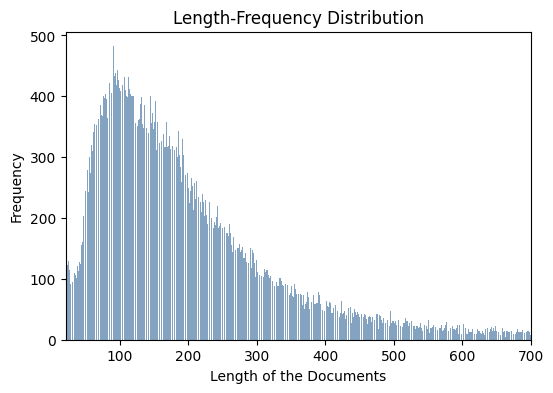

Maximum Length of a Document: 4337
Minimum Length of a Document: 21
Average Length of a Document: 220.0


In [ ]:
import matplotlib
matplotlib.rc_file_defaults()
frequency = dict()
for i in dataset.Length:
    frequency[i] = frequency.get(i, 0)+1

plt.figure(figsize = (6,4))
plt.bar(frequency.keys(), frequency.values(), color=(0.2, 0.4, 0.6, 0.6))
plt.xlim(21, 700)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Documents')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
#plt.savefig(path+'len_dist.png',dpi = 1000,bbox_inches ='tight')
plt.show()  
print(f"Maximum Length of a Document: {max(dataset.Length)}")
print(f"Minimum Length of a Document: {min(dataset.Length)}")
print(f"Average Length of a Document: {round(np.mean(dataset.Length),0)}")


# Dataset Summary

In [ ]:
def data_summary(dataset):
  '''
  This function will print the summary of the dataset

  Args:
  dataset: cleaned texts

  returns:
  documents: Number of document per class
  words: Number of words per class
  u_words: Number of unique words per class
  class_label: name of the categories
  '''
  documents = []
  words = []
  u_words = []
  #total_u_word = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
  # find class names
  class_label = [k for k,v in dataset.Category.value_counts().to_dict().items()]
  for label in class_label: 
    word_list = [word.strip().lower() for t in list(dataset[dataset.Category==label].cleaned) for word in t.strip().split()]
    counts = dict()
    for word in word_list:
      counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list  
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
    documents.append(len(list(dataset[dataset.Category==label].cleaned)))
    # Total Word per class
    words.append(len(word_list))
    # Unique words per class 
    u_words.append(len(np.unique(word_list)))
       
    print("\nClass Name : ",label)
    print("Number of Documents:{}".format(len(list(dataset[dataset.Category==label].cleaned))))  
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Most Frequent Words:\n")
    for k,v in ordered[:10]:
      print("{}\t{}".format(k,v))
  return documents,words,u_words,class_label

# pass the whole dataset into the function

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  Politics
Number of Documents:19958
Number of Words:4533333
Number of Unique Words:111374
Most Frequent Words:

শেখ	33058
প্রধানমন্ত্রী	29122
খালেদা	25963
হয়েছে	21878
হাসিনা	21476
আওয়ামী	20548
বিএনপি	20517
জানান	19840
সরকার	19692
কথা	19408

Class Name :  Education
Number of Documents:11828
Number of Words:2624976
Number of Unique Words:116951
Most Frequent Words:

ঘ	23457
ক	21886
খ	21797
গ	21542
শিক্ষা	17806
হয়েছে	16654
জানান	9768
এক	9554
ঢাকা	8110
বিডিনিউজ	6932

Class Name :  Sports
Number of Documents:11776
Number of Words:2354851
Number of Unique Words:100284
Most Frequent Words:

খেলা	15109
রান	14351
শেষ	10159
দলের	9898
বাংলাদেশ	9223
বিপক্ষে	9213
উইকেট	9057
এক	8986
১	8878
হয়ে	8677

Class Name :  Entertainment
Number of Documents:10024
Number of Words:2140271
Number of Unique Words:122321
Most Frequent Words:

০০	28029
৩০	18919
সংবাদ	17050
১০	11187
নাটক	10613
সকাল	10445
রাত	10201
গান	10030
১২	8663
দুপুর	8376

Class Name :  Crime
Number of Documents:8569
Number of Words

In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data_matrix

## Data Summary Visualization

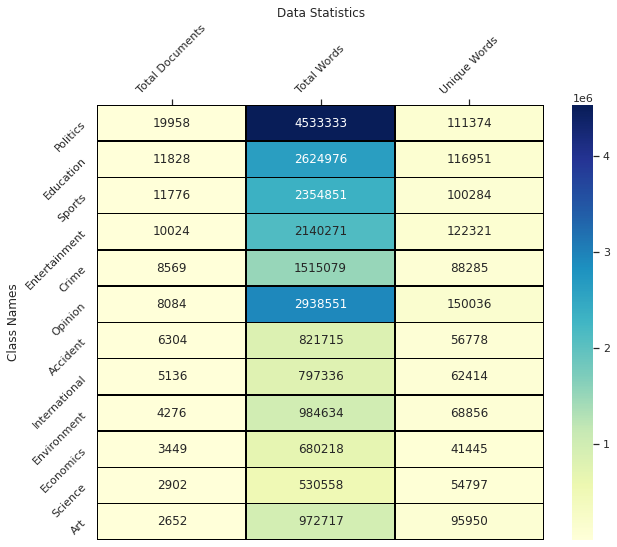

In [ ]:
sns.set()
plt.figure(figsize =(10, 8))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)
# labels, title and ticks
ax.set_ylabel('Class Names') 
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"] 
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()


#Label Encoding and Dataset Splitting

In [ ]:
                   #===========================================================
                   ################# Label Encoding Function ##################
                   #===========================================================
def label_encoding(dataset,bool):
  '''
  This function will convert categorical class names into a numeric label

  Args:
  dataset: A dataset
  bool : a boolean (True or False)

  returns:
  labels: encoded labels 
  '''
  le = LabelEncoder()
  le.fit(dataset.Category)
  encoded_labels = le.transform(dataset.Category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print(color.BOLD+"\n\t\t\t===== Label Encoding ====="+color.END,"\nClass Names:-->",le.classes_)
  return labels  

                   #===========================================================
                   ################# Dataset Splitting Function ###############
                   #=========================================================== 

def dataset_split(news,category):
  '''
  This function will split the dataset into Train-Test-Validation set

  Args:
  news: encoded texts
  category: class names

  returns:
  X_train: Encoded Training News  
  X_valid: Encoded Validation News
  X_test:  Encoded Test news
  y_train: Encoded Training labels
  y_valid: Encoded Validation labels
  y_test:  Encoded Test labels
  '''

  X,X_test,y,y_test = train_test_split(news,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
  X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
  print(color.BOLD+"Feature Size :======>"+color.END,X_train.shape[1])
  print(color.BOLD+"\nDataset Distribution:\n"+color.END)
  print("\tSet Name","\t\tSize")
  print("\t========\t\t======")

  print("\tFull\t\t\t",news.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0],
        "\n\tValidation\t\t",X_valid.shape[0])
  
  return X_train,X_valid,X_test,y_train,y_valid,y_test


#Tokenizer

In [ ]:
def encoded_texts(dataset,padding_length,max_words):

  '''
  This function will encoded the text into a sequence of numbers

  Args:
  dataset: a dataset
  padding_length: maximum length of a encoded texte
  max_words : Number of words 

  returns:
  corpus: Number of encoded texts
  labels: encoded labels
  '''
  
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
  
 

 # Fit the tokenizer
  tokenizer.fit_on_texts(dataset.cleaned)
  #============================== Tokenizer Info =================================
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  def tokenizer_info(mylist,bool):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  #=============================== Print all the information =========================
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
  print("Words --> Counts:")
  tokenizer_info(word_counts,bool =True )
  print("\nWords --> Documents:")
  tokenizer_info(word_docs,bool =True )
  print("\nWords --> Index:")
  tokenizer_info(word_index,bool =True )    
  print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
  sequences = tokenizer.texts_to_sequences(dataset.cleaned)
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))  
  print(dataset.cleaned[10],"\n",sequences[10]) 

  #==================================== Pad Sequences ============================== 
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",dataset.cleaned[10],"\n",corpus[10])   

  #=================================     Label Encoding ================================
  labels = label_encoding(dataset,True)

   # save the tokenizer into a pickle file
  with open(path+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return corpus,labels
  
#call the function
num_words = 5000
corpus,labels = encoded_texts(dataset,
                                300,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)

			====== Tokenizer Info ======
Words --> Counts:
হয়েছে 	 98111
এক 	 90095
জানান 	 68234
কথা 	 64543
০০ 	 53661
সংবাদ 	 49250
গত 	 49111
শেখ 	 46766
সময় 	 46342
সরকার 	 45661

Words --> Documents:
এক 	 49372
হয়েছে 	 41762
জানান 	 35932
কথা 	 33924
গত 	 30133
বিডিনিউজ 	 29178
টোয়েন্টিফোর 	 26960
সময় 	 26937
দিয়ে 	 24426
হয়ে 	 23752

Words --> Index:
হোমও 	 428881
দোয়ের 	 428880
ওইল্যান্ডকে 	 428879
মাইলফলকই 	 428878
রেকর্ডগুলো 	 428877
মণিমাণিক্যখচিত 	 428876
চোটজর্জর 	 428875
ছুটছেই 	 428874
ভিয়ালন 	 428873
ভিয়ালনের 	 428872

Total Documents --> 94958

			====== Encoded Sequences ====== 
Found 428881 unique tokens
নেত্রকোনার জারিয়া রেলওয়ে স্টেশনের রোববার লোকাল ট্রেনের বগি লাইনচ্যুত হয়ে ট্রেন চলাচল বন্ধ রয়েছে শ্যামগঞ্জ জারিয়া রেলওয়ের জারিয়া স্টেশনের বেলা সাড়ে ১১টার লোকাল ২৭১ আপ ট্রেনের বগি লাইনচ্যুত ঘটনায় কমপক্ষে ১০ যাত্রী আহত হয়েছেন পূর্বধলা স্টেশন মাস্টার মো আবু তাহের বিডিনিউজ টোয়েন্টিফোর ডটকমকে ট্রেনটি জারিয়া স্টেশন শ্যামগঞ্জের উদ্দেশে ছেড়ে যাওয়ার পরপরই দুর্ঘটনা ঘটে ট্রেনটি উদ্ধারে

#Call Dataset Split Function

In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(corpus,labels)

Feature Size :======> 300

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 94958 
	Training		 68369 
	Test			 9496 
	Validation		 17093


#Model Defination

In [5]:

embedding_dimension = 128
input_length = 300
vocab_size = 5000
num_classes = 12
batch_size = 64
num_epochs = 10

accuracy_threshold = 0.97


class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 

                            ###############################     CNN network architecture ################
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dimension, input_length = input_length),
tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Dense(28, activation='relu'),
tf.keras.layers.Dense(14, activation='relu'),
keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation='softmax')])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(X_train,
    y_train,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    verbose =1)
    #callbacks = callback_list)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 59, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 59, 128)           98816     
_________________________________________________________________
dense (Dense)                (None, 59, 28)            3612      
_________________________________________________________________
dense_1 (Dense)              (None, 59, 14)            4

In [ ]:
# save the model
tf.keras.models.save_model(model, path+'Document.h5', save_format='h5')
#model.save(path+'Document_Categorization.h5')

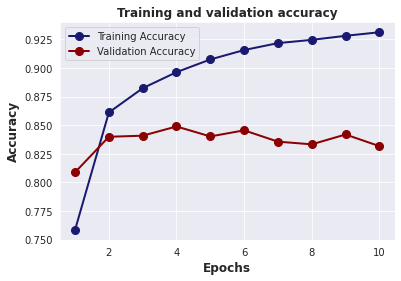

In [ ]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')
                  #=========================================================
                  ############### Epochs vs Validation Accuracy Plot ##########
                  #==========================================================

plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training Accuracy','Validation Accuracy'])

From the **accuracy plot** it is observed that, the validation accuracy not improved more than 85%, it is due to multiclass imbalanced classification probelm. Moreover by proper tunning the vocabulary size the model perfoemance can be improved.

# Model Performance on Test Set

In [ ]:
# Load the saved model
model = load_model(path+'Document_Categorization.h5')

In [ ]:
class_names = ['Accident' ,'Art' ,'Crime', 'Economics' ,'Education' ,'Entertainment',
 'Environment' ,'International' ,'Opinion' ,'Politics', 'Science' ,'Sports']
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Accident','1':'Art','2':'Crime','3':'Economics','4':'Education','5':'Entertainment',
                              '6': 'Environment','7':'International','8':'Opinion','9':'Politics','10':'Science','11':'Sports'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
Accident,94.31,87.94,91.01,622.000000
Art,67.27,39.78,50.00,279.000000
Crime,82.95,88.15,85.47,861.000000
Economics,79.64,88.42,83.80,354.000000
Education,85.07,82.19,83.61,1185.000000
Entertainment,80.84,84.85,82.80,970.000000
Environment,75.24,69.80,72.42,457.000000
International,86.76,84.10,85.41,522.000000
Opinion,76.84,88.27,82.16,827.000000
Politics,83.48,84.90,84.18,1940.000000


By observing precision,recall and f1-score we can see that all the classes are classified reasonably well except **Art and Environment.** 

## Confusion Matrix

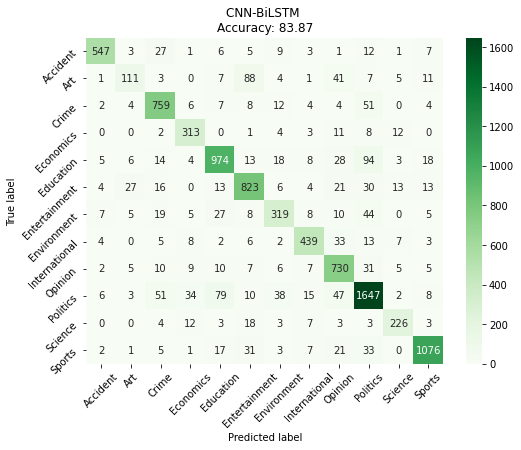

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred) 

class_names = ['Accident' ,'Art' ,'Crime', 'Economics' ,'Education' ,'Entertainment',
 'Environment' ,'International' ,'Opinion' ,'Politics', 'Science' ,'Sports']
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens", fmt='g')
plt.title('CNN-BiLSTM \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()


The confusion matrix provides a good understanding about how many documents are correctly classified in each class and which classes get confused during classification. Here, we can see that Art, Entertainment, Politics category gives larger number of false classified result.  

## Test with our own news 

In [ ]:
sample_news = 'নিহত একরামুল হক নয়ন (৩৬)  শহরের নর্থ বেঙ্গল এলাকার মৃত আছের আলীর ছেলে। ওই এলাকায় ‘আলিফ মেডিকেল স্টোর’ নামে তার একটি ওষুধের দোকান আছে। জেলার সহকারী পুলিশ সুপার (সার্কেল) আদিবুল ইসলাম জানান, মঙ্গলবার রাত সাড়ে ১২টার দিকে শহরের এয়ারপোর্ট এলাকায় ছিনতাইকারীরা নয়নকে কুপিয়ে তার মোটরসাইকেল নিয়ে যায়। ঘটনার পর রাতেই পুলিশ অভিযান চালিয়ে পাঁচ ছিনতাইকারীকে আটক এবং নয়নের মোটরসাইকেলটি উদ্ধার করে বলে জানান তিনি। আদিবুল জানান, নয়ন পরিচিত একজনকে মোটরসাইকেলে করে মহেন্দ্রনগর ইউনিয়নের আমবাড়ী গ্রামে পৌঁছে দিয়ে শহরে ফেরার পথে ছিনতাইকারীর কবলে পড়েন। “ছিনতাইকারীরা নয়নকে আটকে তার মাথায় ধারালো অস্ত্র দিয়ে আঘাত করে। পথচারীরা তাকে উদ্ধার করে রংপুর মেডিকেল কলেজ হাসপাতালে পাঠালে সকালে সেখানে তার মৃত্যু হয়।” ছিনতাকারীদলের বাকি সদস্যদের ধরার চেষ্টা চলছে বলে সহকারী পুলিশ সুপার জানান।'
cleaned_news = cleaning_documents(sample_news)

class_names = ['Accident' ,'Art' ,'Crime', 'Economics' ,'Education' ,'Entertainment',
 'Environment' ,'International' ,'Opinion' ,'Politics', 'Science' ,'Sports']

#print(cleaned_news)
# load the saved tokenizer
with open(path+'tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
#print(len(loaded_tokenizer.word_index))
seq= loaded_tokenizer.texts_to_sequences([cleaned_news])
padded = pad_sequences(seq, value=0.0,padding='post', maxlen= 300 )
pred = model.predict(padded)
#print(pred) 
class_names[np.argmax(pred)]   


'Crime'

In [ ]:
# print top most classes
y_pred = pred.reshape(-1)
class_labels=[(class_names[i],round(prob*100,2)) for i,prob in enumerate(y_pred) if prob > 0.1]

for k, v in class_labels:
  print(k,'====>',v,'%')

Crime ====> 24.52 %
International ====> 17.36 %
Science ====> 22.0 %
